In [12]:
import random;import copy
import pandas as pd
import numpy as np
import sys;import time
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import gamma
from Bio.Seq import Seq
from Bio import Align
from Bio import pairwise2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.metrics import precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras import regularizers
import warnings;warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
class individual:
    def __init__(self):
        self.fitness = 0
        self.pfitness = 0
        self.diversity = 0
        self.genome = []
        self.protein = []
        for i in range(0,genomesize):
            self.genome.append(random.choice(DNAcharacters))
        self.calcFit_DNA()
        self.translate()
        self.calcDiversity()
        self.protein_fitness_score()

    def translate(self):
        dna_str = ''.join(self.genome) 
        dna_str = dna_str[:len(dna_str)//3*3] # truncate the string to make it divisible by 3
        seq = Seq(dna_str)
        self.protein = seq.translate()
        return self.protein     

    def print(self):
        for c in self.genome:
            print(c,end = "")
        for p in self.protein:
            print(p,end = "")
        print("  DNA fitness:" + str(self.fitness))
        print("  Protein fitness:" + str(self.pfitness))
        
    def protein_fitness_score(self):
        amino_acid_scores = {'*':-1,'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
                         'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
                         'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
                         'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
        self.pfitness = 0
        for amino_acid in self.protein:
            if amino_acid in amino_acid_scores:
                self.pfitness += amino_acid_scores[amino_acid]
            else:
                raise ValueError(f"Invalid amino acid '{amino_acid}' in the sequence.")
        return self.pfitness
    
    def calcFit_DNA(self):
        self.fitness = 0
        for i in range(len(self.genome)-1):
            if i + 1 < len(self.genome) and self.genome[i] == 'C' and self.genome[i+1] == 'G':
                self.fitness += 1
        return self.fitness/popsize

    def calcDiversity(self):
        self.diversity = 0
        counts = {}
        for letter in self.genome:
            counts[letter] = counts.get(letter, 0) + 1
        freqs = [count/genomesize for count in counts.values()]
        self.diversity = sum([(f*(1-f)) for f in freqs])
        #print(self.diversity)
        return self.diversity
    
    def mutation(self,mutation_rate):
        for i in range(0,genomesize):
            if(random.uniform(0,100) < mutation_rate):
                self.genome[i] = random.choice(DNAcharacters)
                #mutations.append(mutation_rate)
        self.calcFit_DNA()
        self.calcDiversity()

    def copy(self,source):
        self.fitness = source.fitness
        self.pfitness = source.pfitness
        self.diversity = source.diversity
        for i in range(0,genomesize):
            self.genome[i] = source.genome[i]


In [ ]:
def crossover_rate():
        random.seed(17)
        crossover_rate = random.uniform(0,9)
        return crossover_rate
def crossover_rate_Beta(alpha, beta_param, lower_bound, upper_bound):
    random.seed(17)
    beta_value = beta.rvs(alpha, beta_param)
    crossover_rate = lower_bound + beta_value * (upper_bound - lower_bound)
    return crossover_rate
def mutation_rate_gamma(shape, scale, lower_bound, upper_bound):
    random.seed(17)
    gamma_value = gamma.rvs(shape, scale=scale)
    mutation_rate = lower_bound + gamma_value * (upper_bound - lower_bound)
    return mutation_rate

In [ ]:
# CLASS POPULATION
class population:
    def __init__(self):  
        self.avg_fitness = 0
        self.avg_pfitness = 0
        self.avg_diversity = 0
        self.the_pop = []
        for i in range(0,popsize):
            self.the_pop.append(individual())
    def calcstats(self):
        self.avg_fitness = 0
        for i in self.the_pop:
            self.avg_fitness += i.fitness
        self.avg_fitness /= popsize
    def calcstats2(self):
        self.avg_diversity = 0
        for i in self.the_pop:
            self.avg_diversity += i.diversity
        self.avg_diversity /= popsize
    def calcstats3(self):
        self.avg_pfitness = 0
        for i in self.the_pop:
            self.avg_pfitness += i.pfitness
        self.avg_pfitness /= popsize       
    def generational_tourn2(self,mutation_rate): # tournament + twopoint crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        self.calcstats3()   
    def generational_roulette2(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.roulette()
            parent2 = self.roulette()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        self.calcstats3()
    def tournament(self):
        tourn_size = 2
        best_so_far = random.randint(0,popsize-1)
        best_fitness = self.the_pop[best_so_far].fitness
        for i in range(0,tourn_size - 1):
            current = random.randint(0,popsize-1)
            current_fit = self.the_pop[current].fitness
            if(current_fit > best_fitness):
                best_so_far = current
                best_fitness = current_fit
        return best_so_far
    def roulette(self):  #fitness proportionate selection with default to elite or uniform
        self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
        fit_values = [individual.fitness for individual in self.the_pop]
        #print(fit_values)
        max_fit = max(fit_values)
        sum_fit = sum(fit_values)
        probs = [fit/sum_fit for fit in fit_values]
        U = random.uniform(0, 1)
        C = 0
        for i, prob in enumerate(probs):
            C += prob
            if C > U:
                return i
    def twopoint_crossover(self,p1,p2):
        position1 = random.randint(0,genomesize)
        position2 = random.randint(0,genomesize)
        for j in range(position1, position2):
            temp = self.the_pop[p1].genome[j]
            self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
            self.the_pop[p2].genome[j] = temp

In [ ]:
# set initial parameters
genomesize = 300        # size of genome in an individual
gens = 500              # number of generations of popuation
popsize = 3000           # popuation of individual
DNAcharacters = 'TGCA'  # possible DNA nucleotides on genome

# construct empty lists for data collections
times = []
sizes = []
max_iterations = []
max_iterations2 = []
ave_mutations = []
ave_mutations2 = []
ave_DNA_fitness = []
ave_PROT_fitness = []
ave_DNA_diversity = []
ave_PROT_diversity = []
ave_DNA_fitness2 = []
ave_PROT_fitness2 = []
ave_DNA_diversity2 = []
ave_PROT_diversity2 = []
random_individuals_p1 = []
random_individuals_p2 = []
p1 = population();p2 = population()
ind=[]
mutations1 = [];mutations2 = []
g1=[];g2 =[]
d1 = [];d2 = []
gg1 = [];gg2 =[]
R = [];R2 = []

In [ ]:
# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    protein1 = ''.join(p1.the_pop[i].protein)
    protein2 = ''.join(p2.the_pop[i].protein)
    genome1 = ''.join(p1.the_pop[i].genome)
    genome2 = ''.join(p2.the_pop[i].genome)
    random_individuals_p1.append((1, i, genome1,protein1))
    random_individuals_p2.append((2, i, genome2,protein2))
    mutate1 = mutation_rate_gamma(shape=4, scale=0.4, lower_bound=0.04, upper_bound=0.4)
    mutate2 = mutation_rate_gamma(shape=2, scale=0.2, lower_bound=0.02, upper_bound=0.2)
    mutations1.append(mutate1)
    mutations2.append(mutate2)
    ind.append(i)
    p1.generational_tourn2(mutate1)
    p2.generational_roulette2(mutate2)
    d1.append(p1.avg_diversity)
    d2.append(p2.avg_diversity)
    g1.append(p1.avg_fitness)
    g2.append(p2.avg_fitness)
    gg1.append(p1.avg_pfitness)
    gg2.append(p2.avg_pfitness)
    #protein1 = ''.join(p1.the_pop[i].protein)
    #protein2 = ''.join(p2.the_pop[i].protein)
    #genome1 = ''.join(p1.the_pop[i].genome)
    #genome2 = ''.join(p2.the_pop[i].genome)
    prot1 = (p1.the_pop[i].protein)
    prot2 = (p2.the_pop[i].protein)
    #random_individuals_p1.append((1, i, genome1,protein1))
    #random_individuals_p2.append((2, i, genome2,protein2))
    alignments = pairwise2.align.globalxx(genome1, genome2)
    alignments2 = pairwise2.align.globalxx(prot1, prot2)
    alignment = alignments[0]
    alignment2 = alignments2[0]
    alignment_score = alignment.score
    alignment_score2 = alignment2.score
    r = alignment_score
    r2 = alignment_score2
    R2.append(r2)
    R.append(r)
    print("generation:",i)
end_time = time.time()
#****************************************

In [ ]:
data = {
    'random_individuals_p1': random_individuals_p1,
    'random_individuals_p2': random_individuals_p2,
    'mutations1': mutations1,
    'mutations2': mutations2,
    'g1': g1,
    'g2': g2,
    'd1': d1,
    'd2': d2,
    'gg1': gg1,
    'gg2': gg2,
    'R': R,
    'R2': R2}

df = pd.DataFrame(data)
#df.to_csv('bigrun.csv', index=False)


In [60]:
STATS = pd.read_csv('bigrun.csv')

In [46]:
stat = STATS.drop(['random_individuals_p1', 'random_individuals_p2'], axis=1)
stat

,mutations1,mutations2,g1,g2,d1,d2,gg1,gg2,R,R2
0,0.299821,0.140323,21.026000,19.630667,0.747515,0.747564,1047.169000,1048.096000,185.0,34.0
1,0.576411,0.077045,22.947667,20.374667,0.747429,0.747582,1049.624333,1047.184667,195.0,40.0
2,0.670255,0.068972,24.800333,21.048667,0.747118,0.747486,1048.761000,1048.574333,189.0,37.0
3,0.632842,0.099712,26.447667,21.753667,0.746729,0.747357,1046.605667,1051.227000,189.0,34.0
4,0.881971,0.182683,27.993667,22.465000,0.746292,0.747226,1044.867000,1053.012667,192.0,34.0
...,...,...,...,...,...,...,...,...,...,...
494,0.881979,0.030075,134.161000,99.444333,0.540618,0.608613,1035.280000,1049.299667,247.0,32.0
495,0.438370,0.090282,134.493667,99.338667,0.539232,0.608468,1035.112000,1049.424667,242.0,35.0
496,0.360415,0.082642,134.920667,99.262000,0.538102,0.608716,1035.093333,1049.102667,249.0,34.0
497,1.548121,0.086373,132.917333,99.226000,0.542360,0.608428,1035.074667,1048.534000,249.0,36.0


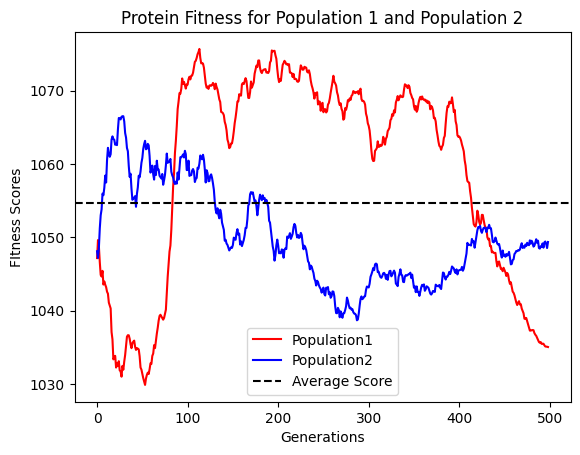

In [52]:
gg1 = stat.gg1
gg2 = stat.gg2
avg_mutation = [sum(scores)/len(scores) for scores in zip(gg1, gg2)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
legend_dict = {'Population1': 'red', 'Population2': 'blue'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
plt.plot(ind, gg1, color=legend_dict['Population1'])
plt.plot(ind, gg2, color=legend_dict['Population2'])
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Score')
plt.legend()
plt.title("Protein Fitness for Population 1 and Population 2")
plt.xlabel("Generations")
plt.ylabel("FItness Scores")
plt.show()

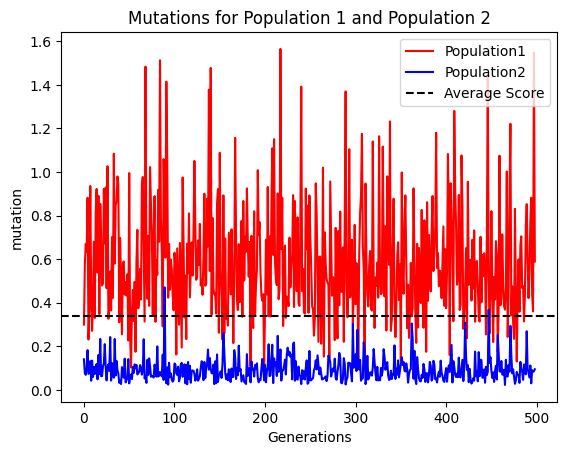

In [91]:
gg1 = stat.mutations1
gg2 = stat.mutations2
avg_mutation = [sum(scores)/len(scores) for scores in zip(gg1, gg2)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
legend_dict = {'Population1': 'red', 'Population2': 'blue'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
plt.plot(ind, gg1, color=legend_dict['Population1'])
plt.plot(ind, gg2, color=legend_dict['Population2'])
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Score')
plt.legend()
plt.title("Mutations for Population 1 and Population 2")
plt.xlabel("Generations")
plt.ylabel("mutation")
plt.show()

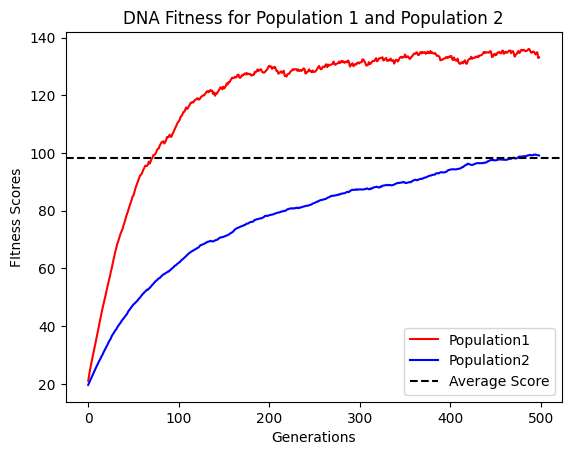

In [48]:
ind = list(range(499))
g1 = stat.g1
g2 = stat.g2
avg_mutation = [sum(scores)/len(scores) for scores in zip(g1, g2)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
legend_dict = {'Population1': 'red', 'Population2': 'blue'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
plt.plot(ind, g1, color=legend_dict['Population1'])
plt.plot(ind, g2, color=legend_dict['Population2'])
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Score')
plt.legend()
plt.title("DNA Fitness for Population 1 and Population 2")
plt.xlabel("Generations")
plt.ylabel("FItness Scores")
plt.show()

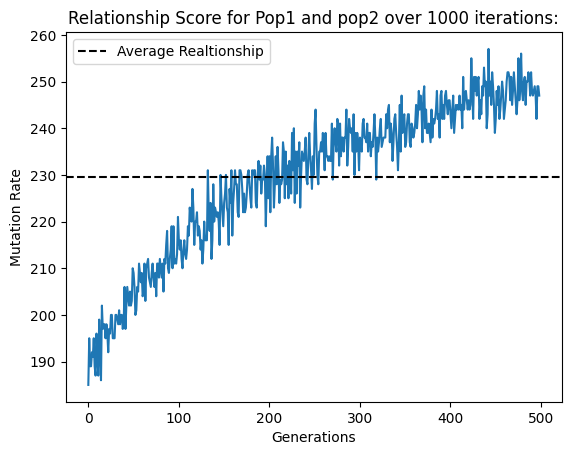

In [49]:
R = stat.R
avg_R = sum(R) / len(R)
plt.plot(ind, R)
plt.axhline(y=avg_R, color='black', linestyle='--', label='Average Realtionship')
plt.legend()
plt.title("Relationship Score (using dna relation) for Pop1 and pop2 over 1000 iterations:")
plt.xlabel("Generations")
plt.ylabel("Mutation Rate")
plt.show()

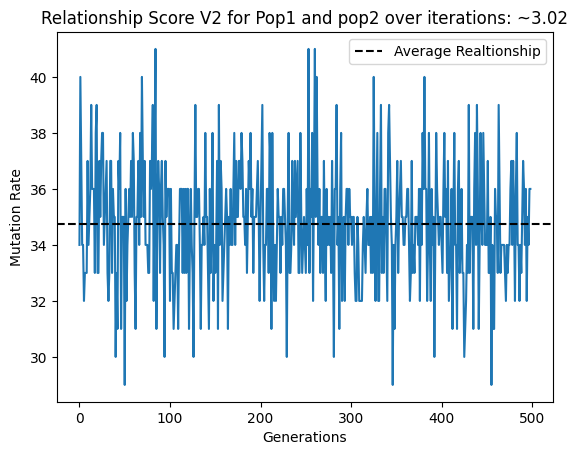

In [50]:
R2 = stat.R2
avg_R = sum(R2) / len(R2)
plt.plot(ind, R2)
plt.axhline(y=avg_R, color='black', linestyle='--', label='Average Realtionship')
plt.legend()
plt.title("Relationship Score (using protein relation) for Pop1 and pop2 over iterations: ~3.02")
plt.xlabel("Generations")
plt.ylabel("Mutation Rate")
plt.show()

In [ ]:
data = random_individuals_p1 + random_individuals_p2
random.shuffle(data)
sequences = [item[2] for item in data]
generation = [item[1] for item in data]
population = [item[0] for item in data] 
population = np.array(population , dtype=np.int32) - 1
#df = pd.DataFrame({'generation': generation,'population': population,'sequence': sequences})
#df.to_csv('genpop.csv', index=False)

## tues noon

In [5]:
df = pd.read_csv('genpop.csv')
X=df.sequence
y=df.population
tokenizer = Tokenizer(num_words=4, char_level=True)
X_encoded = [str(x) for x in X]
tokenizer.fit_on_texts(X_encoded)
X_seq = tokenizer.texts_to_sequences(X_encoded)
X_pad = pad_sequences(X_seq, maxlen=300, padding='post')
X_trainval, X_test, y_trainval, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=17)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(598, 300)
(200, 300)
(200, 300)
(598,)
(200,)
(200,)


In [13]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#plot_model(model1, to_file='model1.png', show_shapes=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model1 = Sequential([Embedding(input_dim=4, output_dim=256, input_length=300),
                    SimpleRNN(units=64),Dense(units=1, activation='sigmoid')])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(X_train, y_train, epochs=10, batch_size=16, 
                     validation_data=(X_val, y_val),callbacks=[tensorboard_callback])

Epoch 1/10
38/38 [==============================] - 10s 236ms/step - loss: 0.4399 - accuracy: 0.8227 - val_loss: 0.3059 - val_accuracy: 0.9000
Epoch 2/10
38/38 [==============================] - 9s 225ms/step - loss: 0.3628 - accuracy: 0.8528 - val_loss: 0.2894 - val_accuracy: 0.9050
Epoch 3/10
38/38 [==============================] - 8s 211ms/step - loss: 0.3761 - accuracy: 0.8528 - val_loss: 0.2975 - val_accuracy: 0.9000
Epoch 4/10
38/38 [==============================] - 9s 241ms/step - loss: 0.3570 - accuracy: 0.8512 - val_loss: 0.2822 - val_accuracy: 0.9000
Epoch 5/10
38/38 [==============================] - 8s 218ms/step - loss: 0.3575 - accuracy: 0.8562 - val_loss: 0.2870 - val_accuracy: 0.9000
Epoch 6/10
38/38 [==============================] - 8s 215ms/step - loss: 0.3497 - accuracy: 0.8579 - val_loss: 0.2903 - val_accuracy: 0.9050
Epoch 7/10
38/38 [==============================] - 8s 220ms/step - loss: 0.3446 - accuracy: 0.8562 - val_loss: 0.2722 - val_accuracy: 0.9050
Epoch

In [8]:
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print(f'Test loss: {loss1:.4f}, Test accuracy: {accuracy1*100:.2f}%')

7/7 [==============================] - 0s 51ms/step - loss: 0.3739 - accuracy: 0.8350
Test loss: 0.3739, Test accuracy: 83.50%


In [14]:
%load_ext tensorboard
%tensorboard --logdir logs

In [16]:
model2 = Sequential([Embedding(input_dim=4, output_dim=16, input_length=300),
                    tf.keras.layers.GRU(units=256),Dense(units=1, activation='sigmoid')])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val),
                      callbacks=[tensorboard_callback])

Epoch 1/10
38/38 [==============================] - 4s 45ms/step - loss: 0.6657 - accuracy: 0.6020 - val_loss: 0.4881 - val_accuracy: 0.8700
Epoch 2/10
38/38 [==============================] - 1s 30ms/step - loss: 0.6024 - accuracy: 0.6823 - val_loss: 0.4331 - val_accuracy: 0.8550
Epoch 3/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3855 - accuracy: 0.8445 - val_loss: 0.2849 - val_accuracy: 0.9050
Epoch 4/10
38/38 [==============================] - 1s 32ms/step - loss: 0.3443 - accuracy: 0.8612 - val_loss: 0.2602 - val_accuracy: 0.9100
Epoch 5/10
38/38 [==============================] - 1s 30ms/step - loss: 0.4096 - accuracy: 0.8428 - val_loss: 0.3043 - val_accuracy: 0.9050
Epoch 6/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3520 - accuracy: 0.8595 - val_loss: 0.2660 - val_accuracy: 0.9000
Epoch 7/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3432 - accuracy: 0.8528 - val_loss: 0.2736 - val_accuracy: 0.9100
Epoch 8/10
38

In [17]:
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print(f'Test loss: {loss2:.4f}, Test accuracy: {accuracy2*100:.2f}%')

7/7 [==============================] - 0s 42ms/step - loss: 0.3632 - accuracy: 0.8500
Test loss: 0.3632, Test accuracy: 85.00%


In [18]:
model3 = Sequential([Embedding(input_dim=4, output_dim=256, input_length=300),LSTM(units=256),
                     Dense(units=1, activation='sigmoid')])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/10
38/38 [==============================] - 3s 42ms/step - loss: 0.4575 - accuracy: 0.8027 - val_loss: 0.2920 - val_accuracy: 0.9000
Epoch 2/10
38/38 [==============================] - 1s 30ms/step - loss: 0.3585 - accuracy: 0.8562 - val_loss: 0.2931 - val_accuracy: 0.8900
Epoch 3/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3557 - accuracy: 0.8595 - val_loss: 0.2587 - val_accuracy: 0.9000
Epoch 4/10
38/38 [==============================] - 1s 28ms/step - loss: 0.3424 - accuracy: 0.8612 - val_loss: 0.2634 - val_accuracy: 0.9000
Epoch 5/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3548 - accuracy: 0.8579 - val_loss: 0.2742 - val_accuracy: 0.9000
Epoch 6/10
38/38 [==============================] - 1s 30ms/step - loss: 0.3414 - accuracy: 0.8645 - val_loss: 0.2574 - val_accuracy: 0.9050
Epoch 7/10
38/38 [==============================] - 1s 29ms/step - loss: 0.3321 - accuracy: 0.8645 - val_loss: 0.2804 - val_accuracy: 0.8950
Epoch 8/10
38

In [21]:
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print(f'Test loss: {loss3:.4f}, Test accuracy: {accuracy3*100:.2f}%')

7/7 [==============================] - 0s 49ms/step - loss: 0.3702 - accuracy: 0.8400
Test loss: 0.3702, Test accuracy: 84.00%


In [24]:
model4 = Sequential()
model4.add(Embedding(input_dim=4, output_dim=128, input_length=300))
model4.add(Bidirectional(LSTM(units=128, dropout=0.01, recurrent_dropout=0.01, 
                             kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))))
model4.add(Dropout(0.3))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/6
19/19 [==============================] - 45s 2s/step - loss: 56.4578 - accuracy: 0.7057 - val_loss: 43.9621 - val_accuracy: 0.9100
Epoch 2/6
19/19 [==============================] - 41s 2s/step - loss: 34.9107 - accuracy: 0.8378 - val_loss: 25.4796 - val_accuracy: 0.9050
Epoch 3/6
19/19 [==============================] - 42s 2s/step - loss: 19.0340 - accuracy: 0.8562 - val_loss: 12.4169 - val_accuracy: 0.9000
Epoch 4/6
19/19 [==============================] - 41s 2s/step - loss: 8.5745 - accuracy: 0.7893 - val_loss: 4.7939 - val_accuracy: 0.9000
Epoch 5/6
19/19 [==============================] - 41s 2s/step - loss: 2.9050 - accuracy: 0.8579 - val_loss: 1.4015 - val_accuracy: 0.9050
Epoch 6/6
19/19 [==============================] - 41s 2s/step - loss: 1.1520 - accuracy: 0.8612 - val_loss: 0.7947 - val_accuracy: 0.9050


In [25]:
loss4, accuracy4 = model4.evaluate(X_test, y_test)
print(f'Test loss: {loss4:.4f}, Test accuracy: {accuracy4*100:.2f}%')

7/7 [==============================] - 2s 195ms/step - loss: 0.8873 - accuracy: 0.8450
Test loss: 0.8873, Test accuracy: 84.50%


In [26]:
data = {'Model': ['SimpleRNN', 'GRU', 'LSTM1', 'LSTM2'],
        'Loss': [loss1, loss2, loss3, loss4],
        'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4]}
deepmetrics = pd.DataFrame(data)
print(deepmetrics )

       Model      Loss  Accuracy
0  SimpleRNN  0.373888     0.835
1        GRU  0.363224     0.850
2      LSTM1  0.370173     0.840
3      LSTM2  0.887331     0.845


In [35]:
data = {'Model': ['SimpleRNN', 'GRU', 'LSTM1', 'LSTM2'],
        'Loss': [loss1, loss2, loss3, loss4],
        'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4]}

df = pd.DataFrame(data)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = df.style \
    .highlight_max(color='yellow') \
    .set_caption('Deep Learning Model Metrics') \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', 'blue'), ('font-size', '18px')]
        },
        {'selector': 'th',
         'props': [('background-color', 'lightgray'), ('color', 'black'), ('font-size', '16px'), ('text-align', 'center')]
        },
        {'selector': 'td',
         'props': [('font-size', '14px'), ('text-align', 'center')]} ])
display(styled_df)

,Model,Loss,Accuracy
0,SimpleRNN,0.373888,0.835000
1,GRU,0.363224,0.850000
2,LSTM1,0.370173,0.840000
3,LSTM2,0.887331,0.845000


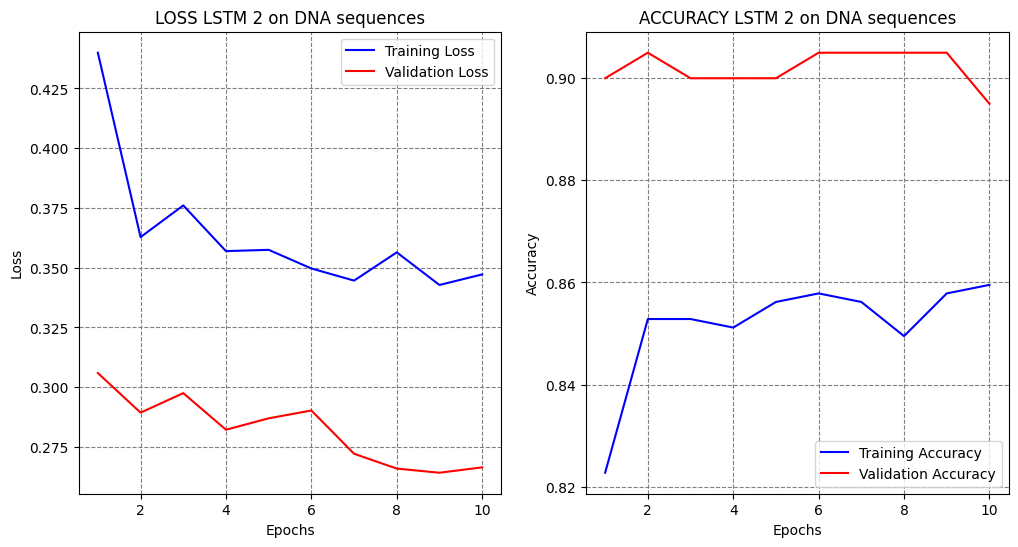

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']
epochsn = np.arange(1, len(train_loss)+1,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochsn,train_loss, 'b', label='Training Loss')
ax1.plot(epochsn,val_loss, 'r', label='Validation Loss')
ax1.grid(color='gray', linestyle='--')
ax1.legend()
ax1.set_title('LOSS LSTM 2 on DNA sequences')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(epochsn, acc, 'b', label='Training Accuracy')
ax2.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
ax2.grid(color='gray', linestyle='--')
ax2.legend()            
ax2.set_title('ACCURACY LSTM 2 on DNA sequences')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

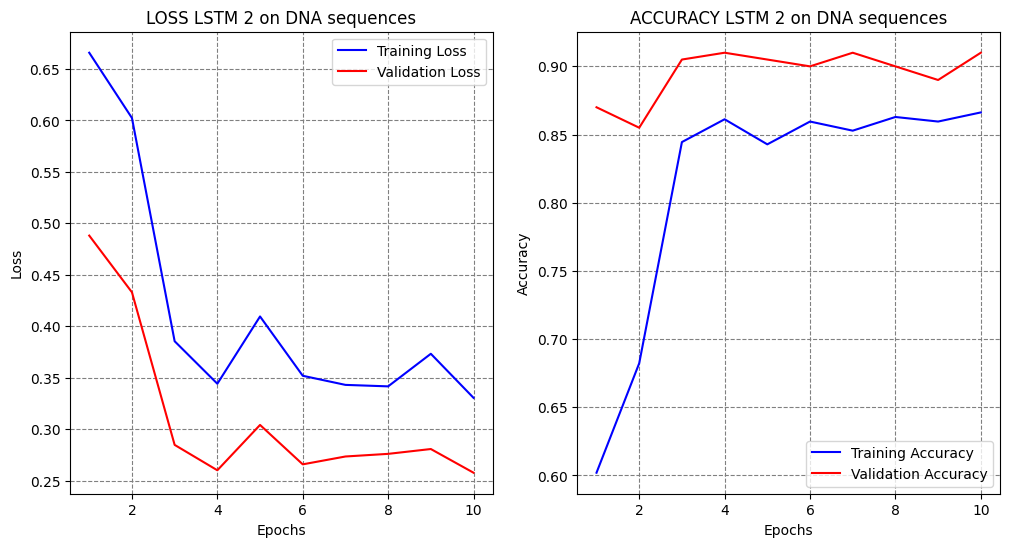

In [32]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history['accuracy'] 
val_acc = history2.history['val_accuracy']
epochsn = np.arange(1, len(train_loss)+1,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochsn,train_loss, 'b', label='Training Loss')
ax1.plot(epochsn,val_loss, 'r', label='Validation Loss')
ax1.grid(color='gray', linestyle='--')
ax1.legend()
ax1.set_title('LOSS LSTM 2 on DNA sequences')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(epochsn, acc, 'b', label='Training Accuracy')
ax2.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
ax2.grid(color='gray', linestyle='--')
ax2.legend()            
ax2.set_title('ACCURACY LSTM 2 on DNA sequences')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

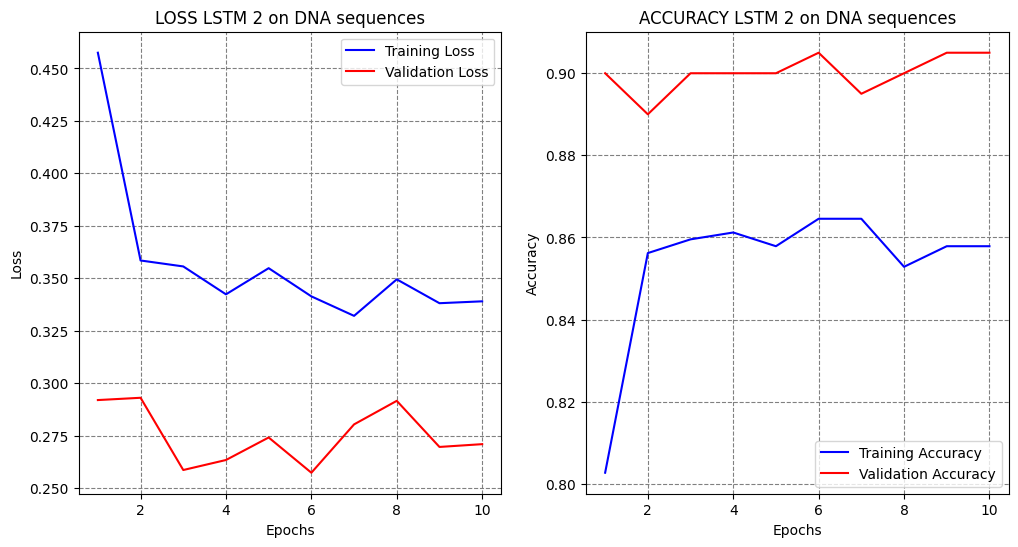

In [33]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
acc = history3.history['accuracy'] 
val_acc = history3.history['val_accuracy']
epochsn = np.arange(1, len(train_loss)+1,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochsn,train_loss, 'b', label='Training Loss')
ax1.plot(epochsn,val_loss, 'r', label='Validation Loss')
ax1.grid(color='gray', linestyle='--')
ax1.legend()
ax1.set_title('LOSS LSTM 2 on DNA sequences')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(epochsn, acc, 'b', label='Training Accuracy')
ax2.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
ax2.grid(color='gray', linestyle='--')
ax2.legend()            
ax2.set_title('ACCURACY LSTM 2 on DNA sequences')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

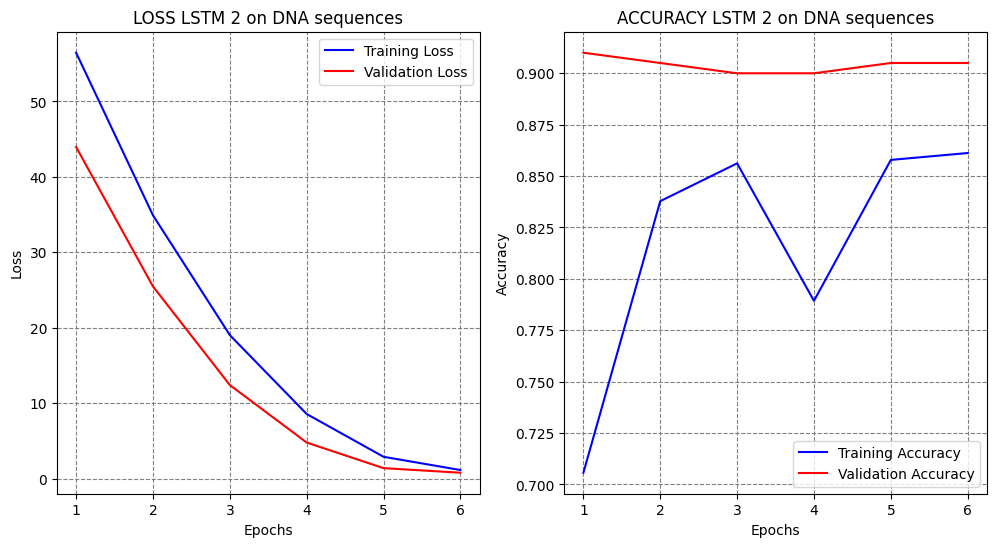

In [29]:
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
acc = history4.history['accuracy'] 
val_acc = history4.history['val_accuracy']
epochsn = np.arange(1, len(train_loss)+1,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochsn,train_loss, 'b', label='Training Loss')
ax1.plot(epochsn,val_loss, 'r', label='Validation Loss')
ax1.grid(color='gray', linestyle='--')
ax1.legend()
ax1.set_title('LOSS LSTM 2 on DNA sequences')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(epochsn, acc, 'b', label='Training Accuracy')
ax2.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
ax2.grid(color='gray', linestyle='--')
ax2.legend()            
ax2.set_title('ACCURACY LSTM 2 on DNA sequences')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()


K Nearest Neighbors: 0.8694915254237289 (0.04164592991597359)
Gaussian Process: 0.8778531073446327 (0.026341016482862658)
Decision Tree: 0.8578531073446328 (0.03116289129706656)
Random Forest: 0.8445480225988702 (0.03334985944827121)
Neural Net: 0.8947175141242937 (0.03788535813065755)
AddaBoost: 0.8763276836158193 (0.02892545019081676)
Naive Bayes: 0.8544915254237289 (0.038222218000336754)
SVM Linear: 0.8712994350282486 (0.04525987960057683)
SVM RBF: 0.8828531073446328 (0.039809075853987845)
SVM Sigmoid: 0.4765819209039548 (0.03819778356590719)


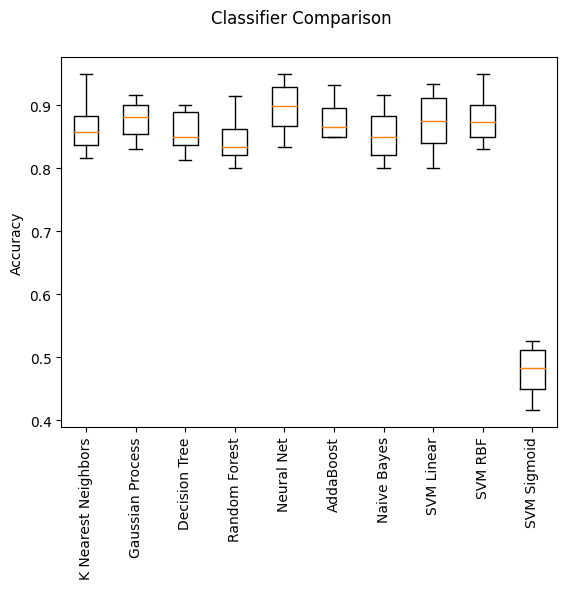

In [41]:
scoring = 'accuracy'
names = ['K Nearest Neighbors', 'Gaussian Process', 'Decision Tree', 
         'Random Forest', 'Neural Net', 'AddaBoost', 'Naive Bayes', 'SVM Linear', 'SVM RBF', 'SVM Sigmoid']
Classifiers = [KNeighborsClassifier(n_neighbors = 3),
               GaussianProcessClassifier(1.0*RBF(1.0)),
               DecisionTreeClassifier(max_depth = 5),
               RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
               MLPClassifier(alpha = 1),
               AdaBoostClassifier(),
               GaussianNB(),
               svm.SVC(kernel = 'linear'),
               svm.SVC(kernel = 'rbf'),
               svm.SVC(kernel = 'sigmoid')]

models = zip(names, Classifiers)
names = []
result = []

for name, model in models:
    kfold = KFold(n_splits = 10)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    result.append(cv_results)
    names.append(name)
    msg = "{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(result)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.show()

In [38]:

scoring = 'accuracy'
names = ['K Nearest Neighbors', 'Gaussian Process', 'Decision Tree', 
         'Random Forest', 'Neural Net', 'AddaBoost', 'Naive Bayes', 'SVM Linear', 'SVM RBF', 'SVM Sigmoid']
Classifiers = [KNeighborsClassifier(n_neighbors = 3),
               GaussianProcessClassifier(1.0*RBF(1.0)),
               DecisionTreeClassifier(max_depth = 5),
               RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
               MLPClassifier(alpha = 1),
               AdaBoostClassifier(),
               GaussianNB(),
               svm.SVC(kernel = 'linear'),
               svm.SVC(kernel = 'rbf'),
               svm.SVC(kernel = 'sigmoid')]

models = zip(names, Classifiers)
results = []

for name, model in zip(names, Classifiers):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision})

# Convert the results to a DataFrame
dd = pd.DataFrame(results)
dd


,Model,Accuracy,Precision
0,K Nearest Neighbors,0.875,0.875450
1,Gaussian Process,0.810,0.810269
2,Decision Tree,0.880,0.881161
3,Random Forest,0.810,0.810269
4,Neural Net,0.910,0.911325
5,AddaBoost,0.875,0.876591
6,Naive Bayes,0.820,0.866619
7,SVM Linear,0.860,0.860060
8,SVM RBF,0.870,0.891978
9,SVM Sigmoid,0.515,0.265225


In [40]:
styled_df = dd.style \
    .highlight_max(color='yellow') \
    .set_caption('Popular Machine Learning Model Metrics') \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', 'blue'), ('font-size', '18px')]
        },
        {'selector': 'th',
         'props': [('background-color', 'lightgray'), ('color', 'black'), ('font-size', '16px'), ('text-align', 'center')]
        },
        {'selector': 'td',
         'props': [('font-size', '14px'), ('text-align', 'center')]} ])
display(styled_df)

,Model,Accuracy,Precision
0,K Nearest Neighbors,0.875000,0.875450
1,Gaussian Process,0.810000,0.810269
2,Decision Tree,0.880000,0.881161
3,Random Forest,0.810000,0.810269
4,Neural Net,0.910000,0.911325
5,AddaBoost,0.875000,0.876591
6,Naive Bayes,0.820000,0.866619
7,SVM Linear,0.860000,0.860060
8,SVM RBF,0.870000,0.891978
9,SVM Sigmoid,0.515000,0.265225


In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Classifier Comparison', fontsize=16)
ax.set_ylabel('Accuracy')
ax.set_xticklabels(names, fontsize=8, rotation=80)

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', 
          '#64B5CD', '#4D4D4D', '#FFA07A', '#A9A9A9', '#FFD700']

for i in range(len(names)):
    ax.bar(names[i], np.mean(result[i]), align='center',
           alpha=0.8, ecolor='black', capsize=1, color=colors[i])

ax.set_ylim([0.4, 1.0])
plt.tight_layout()
plt.show()


In [71]:
d1 = stat.d1
d2 = stat.d2
p1 = STATS.random_individuals_p1
p2 = STATS.random_individuals_p2
print("Max DNA Fitness Score for population 1: ",max(g1))
print("Max DNA Fitness Score for population 2: ",max(g2))
print("Max Protein Fitness Score for population 1: ",max(gg1))
print("Max Protein Fitness Score for population 2: ",max(gg2))
print("Average Diversity Score for population 1 ",np.mean(d1))
print("Average Diversity Score for population 2 ",np.mean(d2))
print("p1 size in bytes: ", sys.getsizeof(p1))
print("p2 size in bytes: ", sys.getsizeof(p2))


protein1 = p1[0]
protein2 = p2[0]
aligner = Align.PairwiseAligner()
alignments = aligner.align(protein1, protein2)
alignment = alignments[0]
print(alignment)
score = alignment.score
print(score)


Max DNA Fitness Score for population 1:  136.066
Max DNA Fitness Score for population 2:  99.44433333333332
Max Protein Fitness Score for population 1:  1075.698666666667
Max Protein Fitness Score for population 2:  1066.5203333333334
Average Diversity Score for population 1  0.5802641887924003
Average Diversity Score for population 2  0.6659330015586731
p1 size in bytes:  236063
p2 size in bytes:  236063
target            0 (1-, 1---, 'GCA-C--C--C-CCG--TAG---GAAC-CATGGA-GT----GCGACGC
                  0 |--||----|||||--|--|--|-|||--|-|---|--|-|--||--||----|||-|||
query             0 (-2, -489, 'GC-GCGGCGACGCCGCGT-GCTCG--CGC--GG-CGTACCCGCG-CGC

target           39 -T-GAACAG-GA--G--AA--G--TGTAT-C--AATATTTTAA-G-------TA-GC--G
                 60 -|-|--|-|-|---|--|---|--||||--|--|----------|-------|--||--|
query            50 GTCG--C-GCG-CCGCGA-CCGCGTGTA-GCGGA---------CGGCGCGCGT-CGCCCG

target           74 TA-GC-CGCAA-T-GCTAATAT-C-AGCTA-C-C-CC-ATTTC-GTATTA-GAACTAC-C
                120 |-

In [ ]:
protein1 = p1[0]
protein2 = p2[0]
aligner = Align.PairwiseAligner()
alignments = aligner.align(protein1, protein2)
alignment = alignments[0]
print(alignment)
score = alignment.score
print(score)

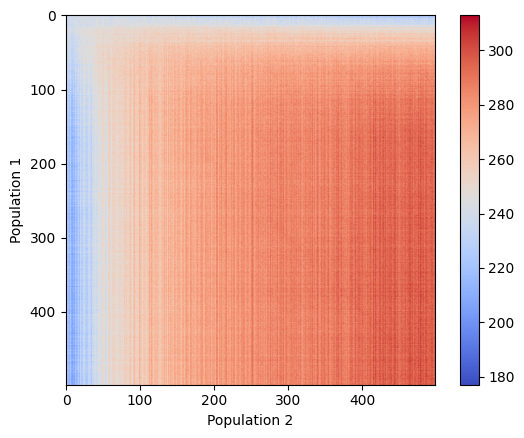

In [72]:
scores = np.zeros((len(p1), len(p2)))

for i in range(len(p1)):
    for j in range(len(p2)):
        # Align the two proteins
        alignments = aligner.align(p1[i], p2[j])
        alignment = alignments[0]
        score = alignment.score
        scores[i, j] = score
plt.imshow(scores, cmap='coolwarm')
plt.xlabel('Population 2')
plt.ylabel('Population 1')
plt.colorbar()
plt.show()

In [86]:
from Bio import Align
import random

# Assume genomes is a list of evolved genomes from a GA
genomes = X_train

# Select a subset of genomes
subset = [genomes[i] for i in range(0, len(genomes), 10)]

# Shuffle the order of the subset
random.shuffle(subset)

# Initialize the aligner
aligner = Align.PairwiseAligner()

# Create a matrix of the alignment scores between each pair of genomes
alignment_matrix = []
for i in range(len(subset)):
    row = []
    for j in range(len(subset)):
        alignments = aligner.align(subset[i], subset[j])
        alignment = alignments[0]
        score = alignment.score
        row.append(score)
    alignment_matrix.append(row)

# Print the alignment matrix
print(alignment_matrix)


[[300.0, 239.0, 236.0, 240.0, 236.0, 238.0, 239.0, 199.0, 236.0, 236.0, 245.0, 225.0, 245.0, 235.0, 238.0, 214.0, 243.0, 238.0, 241.0, 240.0, 235.0, 235.0, 208.0, 242.0, 232.0, 230.0, 236.0, 241.0, 237.0, 243.0, 212.0, 238.0, 236.0, 235.0, 241.0, 233.0, 245.0, 231.0, 237.0, 240.0, 235.0, 236.0, 218.0, 234.0, 231.0, 243.0, 234.0, 233.0, 243.0, 241.0, 245.0, 204.0, 240.0, 204.0, 238.0, 242.0, 235.0, 223.0, 246.0, 234.0], [239.0, 300.0, 241.0, 246.0, 240.0, 242.0, 242.0, 207.0, 235.0, 237.0, 246.0, 230.0, 247.0, 244.0, 243.0, 222.0, 242.0, 242.0, 244.0, 249.0, 243.0, 242.0, 221.0, 249.0, 236.0, 238.0, 239.0, 249.0, 239.0, 239.0, 219.0, 240.0, 239.0, 241.0, 245.0, 241.0, 244.0, 243.0, 241.0, 239.0, 239.0, 239.0, 228.0, 237.0, 241.0, 238.0, 240.0, 235.0, 239.0, 241.0, 245.0, 212.0, 246.0, 215.0, 237.0, 245.0, 241.0, 233.0, 242.0, 237.0], [236.0, 241.0, 300.0, 250.0, 276.0, 275.0, 276.0, 182.0, 256.0, 232.0, 248.0, 222.0, 278.0, 277.0, 258.0, 206.0, 235.0, 272.0, 268.0, 255.0, 233.0, 274.0, 

In [90]:
from Bio import Align
import random

# Assume genomes is a list of evolved genomes from a GA
genomes = STATS.random_individuals_p1
#p2 = STATS.random_individuals_p2

# Select a subset of genomes at known generations
generation_100 = genomes[100]
generation_200 = genomes[200]
generation_300 = genomes[300]

# Select a sequence to estimate the generation of
sequence = genomes[150]

# Initialize the aligner
aligner = Align.PairwiseAligner()

# Align the sequence with each of the known-generation genomes
alignments_100 = aligner.align(sequence, generation_100)
alignments_200 = aligner.align(sequence, generation_200)
alignments_300 = aligner.align(sequence, generation_300)

# Calculate the similarity score between the sequence and each known-generation genome
score_100 = alignments_100[0].score
score_200 = alignments_200[0].score
score_300 = alignments_300[0].score

# Determine the estimated generation based on the highest similarity score
if score_100 >= score_200 and score_100 >= score_300:
    estimated_generation = 100
elif score_200 >= score_100 and score_200 >= score_300:
    estimated_generation = 200
elif score_300 >= score_100 and score_300 >= score_200:
    estimated_generation = 300
else:
    # Handle the case where the scores are equal
    if score_100 == score_200 and score_100 == score_300:
        estimated_generation = 200  # Pick any of the known-generation values
    elif score_100 == score_200:
        estimated_generation = 100  # Pick the lower known-generation value
    elif score_100 == score_300:
        estimated_generation = 100  # Pick the lower known-generation value
    else:  # score_200 == score_300
        estimated_generation = 200  # Pick the lower known-generation value


# Print the estimated generation
print(f"The estimated generation of the sequence is {estimated_generation}.")


The estimated generation of the sequence is 300.
